In [ ]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
[Step 1] 데이터 준비 - Seaborn에서 제공하는 titanic 데이터셋 가져오기
'''

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')


'''
[Step 2 ~ 3] 데이터 전처리
'''

# 중복 데이터 제거
df = df.drop_duplicates()

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - NaN 값
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].mode()[0]    
rdf['embarked'] = rdf['embarked'].fillna(most_freq)

'''
[Step 4] 변수 선택
'''

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf = ndf.drop(['sex', 'embarked'], axis=1)


'''
[Step 5] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)
'''

# 속성(변수) 선택
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y = ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
# *** 데이터 누수 존재o, 사용 ㄴㄴ
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (474, 9)
test data 개수:  (204, 9)


# 기존 데이터 전처리

# 지도학습 Supervised Learning
- 정답이 있음
- 분류와 회귀 둘 다 가능, but 분류에 특화된 모델

## SVM (Support Vector Machine)
- 결정경계(hyperplane): 데이터를 두 클래스로 나누는 경계 (2차원: 직선, 3차원: 평면)
- 서포트 벡터: 하이퍼 플레인에 가장 가까운 data points -> 결정경계에 영향을 줌
- 마진: _하이퍼 플레인_ 과 _서포트 벡터_ 간의 거리 <br>
- => svm은 **마진을 최대화**하여 일반화 성능을 높인다.
- 스케일링 중요

![](2025-10-15-09-26-33.png)!

In [98]:
'''
[Step 6] SVM 분류 모형 - sklearn 사용
'''

# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
# kernel -> 데이터를 벡터 공간으로 매핑하는 함수
# RBF, Linear, Polynimial, Sigmoid
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[1 1 0 1 0 0 0 1 1 1]
[1 1 0 1 0 1 1 1 1 0]


In [99]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)

[[104  19]
 [ 24  57]]


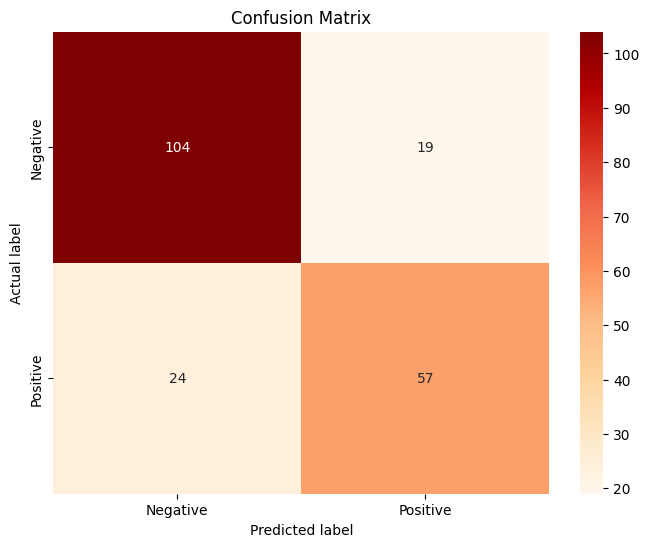

In [100]:
# Confusion Matrix 시각화

plt.figure(figsize=(8, 6))
sns.heatmap(svm_matrix, annot=True, fmt='d', cmap='OrRd', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [101]:
# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



### KNN과 비교하기

In [102]:
# 동일 조건에 knn학습 -> classification_report 결과 확인

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn_model.predict(X_test)

In [103]:
knn_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(knn_matrix)

[[99 24]
 [26 55]]


In [104]:
knn_report = metrics.classification_report(y_test, y_hat)            
print(knn_report)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       123
           1       0.70      0.68      0.69        81

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.75       204



In [105]:
# 최종결과 비교
print(f'<knn_report> {knn_report}')
print(f'<svm_report> {svm_report}')

<knn_report>               precision    recall  f1-score   support

           0       0.79      0.80      0.80       123
           1       0.70      0.68      0.69        81

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.75       204

<svm_report>               precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



#  예제1

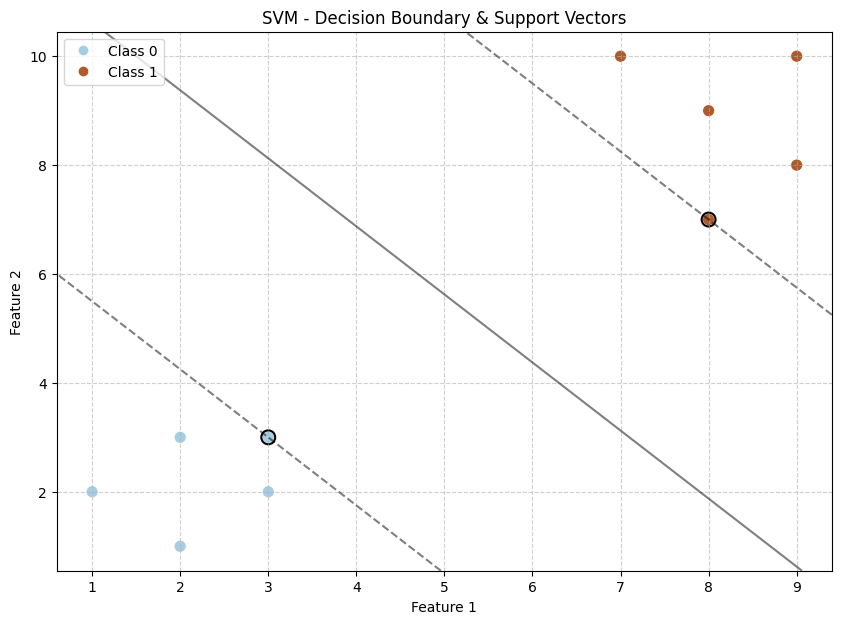

서포트 벡터:
 [[3. 3.]
 [8. 7.]]

서포트 벡터의 인덱스: [2 8]


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# 1. 샘플 데이터 생성
# 두 개의 클래스로 명확하게 구분되는 간단한 데이터를 만듭니다.
X = np.array([[1, 2], [2, 3], [3, 3], [2, 1], [3, 2], # 클래스 0
              [8, 9], [7, 10], [9, 10], [8, 7], [9, 8]]) # 클래스 1
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# 2. SVM 모델 생성 및 학습
# 선형 SVM 모델을 생성하고 데이터에 맞게 학습시킵니다.
# kernel='linear'는 직선(초평면)으로 데이터를 나눈다는 의미입니다.
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

# 3. 시각화
plt.figure(figsize=(10, 7))

# 학습 데이터 포인트(산점도) 그리기
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.title('SVM - Decision Boundary & Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# 그래프의 축 범위 가져오기
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 결정 경계를 그리기 위한 그리드 생성
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# 결정 경계와 마진 그리기
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# 서포트 벡터(Support Vectors) 강조해서 그리기
# 서포트 벡터는 모델의 support_vectors_ 속성에 저장되어 있습니다.
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1.5, facecolors='none', edgecolors='k')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 학습된 모델의 정보 출력
print("서포트 벡터:\n", clf.support_vectors_)
print("\n서포트 벡터의 인덱스:", clf.support_)

#  예제2 - Iris
- 붓꽃의 품종을 분류하는 모델 만들기
- svm, knn

In [107]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [108]:
# class 확인
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [109]:
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [110]:
X=iris.data
y=iris.target

X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [111]:
# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
# 데이터 누수 방지
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn import svm

svm_iris = svm.SVC(kernel='rbf')

svm_iris.fit(X_train_scaled, y_train)
y_hat = svm_iris.predict(X_test_scaled)

print(y_hat[0:10])
print(y_test[0:10])

[1 2 0 1 0 1 1 1 0 1]
[1 2 0 1 0 1 1 1 0 1]


In [114]:
from sklearn import metrics 
svm_matrix_iris = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix_iris)

[[14  0  0]
 [ 0 17  0]
 [ 0  0 14]]


In [115]:
# Iris 데이터셋은 너무 간단해서 SVM이 거의 완벽하게 분리 가능할 수도
svm_report_iris = metrics.classification_report(y_test, y_hat)            
print(svm_report_iris)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        14

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [116]:
# knn
knn_iris = KNeighborsClassifier()

knn_iris.fit(X_train_scaled,y_train)
y_hat = knn_iris.predict(X_test_scaled)

print(y_hat[0:10])
print(y_test[0:10])

[1 2 0 1 0 1 2 1 0 1]
[1 2 0 1 0 1 1 1 0 1]


In [117]:
from sklearn import metrics 
knn_matrix_iris = metrics.confusion_matrix(y_test, y_hat)  
print(knn_matrix_iris)

[[14  0  0]
 [ 0 15  2]
 [ 0  0 14]]


In [118]:
knn_report_iris = metrics.classification_report(y_test, y_hat)  
print(knn_report_iris)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.88      0.94        17
           2       0.88      1.00      0.93        14

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [119]:
# 최종결과 비교
print(f'<svm> {svm_report_iris}')
print(f'<knn> {knn_report_iris}')

<svm>               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        14

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

<knn>               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.88      0.94        17
           2       0.88      1.00      0.93        14

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



# SVM margin 조정
- 가장 안정적으로 나눌 수 있는 최적의 경계선

### 매개변수 C, Gammma
#### > C 값 (Regularzation Parameter)
- C 높게 설정: 하드 마진
- C 낮게 설정: 소프트 마진 (이상치 허용 범위 넓) 
#### > Gamma 값 (Kernel Cofficient)
관측치가 영향력을 행사하는 거리 조정
- 클수록 작은 표준편차

## SVM - Hard margin

In [123]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris

iris = load_iris()
X=iris.data[:,[2,3]] # 꽃잎 길이 넓잉
y=iris.target

In [ ]:
# 품종은 setosa versicolor 0 1
mask = (y==0) | (y==1)
X = X[mask]
y = y[mask]

# C -> 규제(마진 오류 허용 정도 제어)
#    => inf(무한대)로 설정 -> 마진오류 허용x(하드마진)) -> 모든 데이터를 완벽하게 직선으로 나누라고 지도
svm_clf = SVC(kernel='linear', C=float('inf'))
svm_clf.fit(X,y)

,C,inf
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


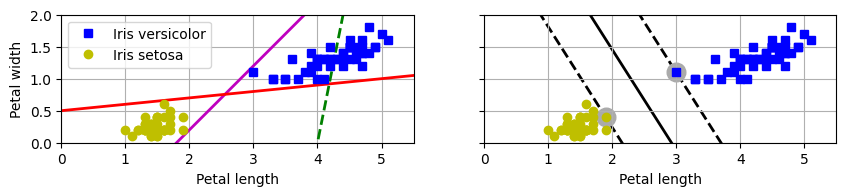

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]


# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float('inf'))
svm_clf.fit(X, y)

# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

# --------------------------------------------------------------------
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

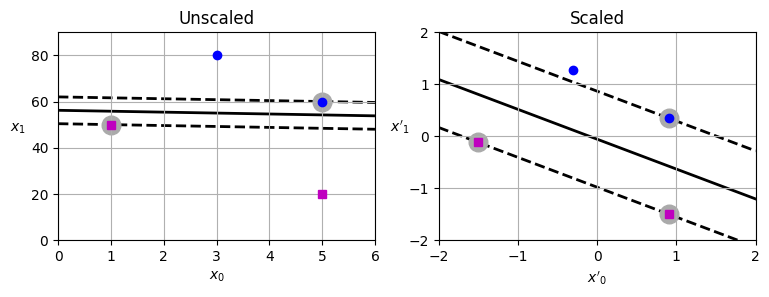

In [ ]:
# 스케일에 민감
# 스케일이 다른 가상의 데이터 생성
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

# --------------------------------------------------------------------
plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()



## SVM - Soft margin

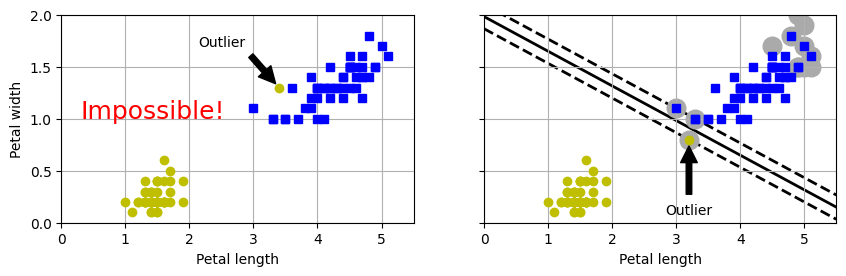

In [128]:
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

# 비선형 SVM 분류
- polyniminal, sigmoid

(np.float64(-4.5), np.float64(4.5), np.float64(-1.0), np.float64(17.0))

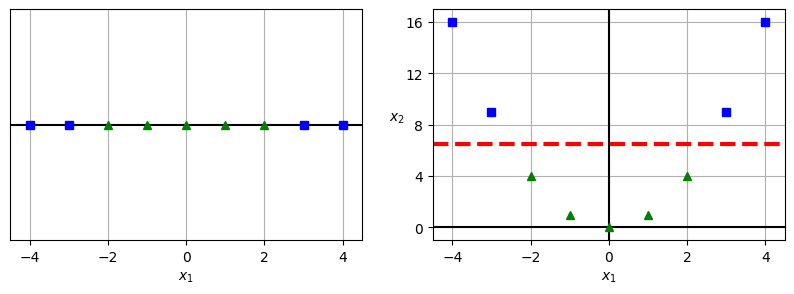

In [129]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])


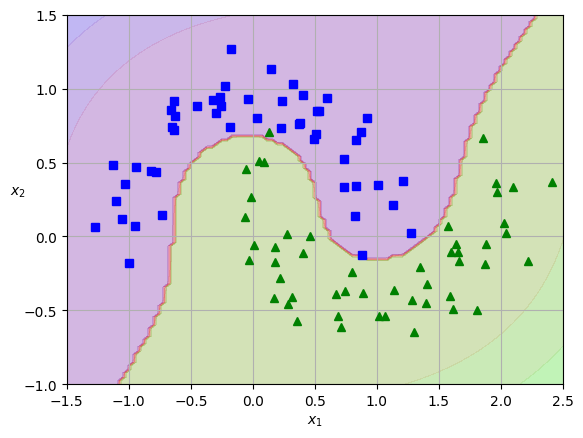

In [130]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])